# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
# Count Vectorizer is in this library
from sklearn.feature_extraction.text import *

/Users/danielleadler/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/danielleadler/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)

# num_test divided by 2 is a float, so we need to make it an integer to index it
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
### STUDENT START ###

    # Iterating through the number of text examples in the dataset
    for i in range(num_examples):
        
        # We can call the label name by matching up the train_label number to 
        # the newsgroups_train label
        print("\n","example number: " + "\033[1m", i + 1, 
              "\033[0m" + "\ntrain label: " + "\033[1m", 
              newsgroups_train.target_names[train_labels[i]],
              "\033[0m" + "\ntrain data: \n", train_data[i], 
              "\n\n----------", sep="")

### STUDENT END ###
P1()


example number: 1
train label: comp.graphics
train data: 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

----------

example number: 2
train label: talk.religion.misc
train data: 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcake

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
### STUDENT START ###

    print("\033[1m" + "Question: A" + "\033[0m")
    # Initializing the class CountVectorizer() to a variable
    CV_train = CountVectorizer()

    # Fitting and transforming the data into a vector
    fit_train = CV_train.fit_transform(train_data)

    print("num of unique words in the train dataset: ", fit_train.shape[1])

    # Counting the number of nonzero features in each sentence is essentially
    # counting the number of words in the sentence and the array shows which words
    # are present in the sentence out of all the unique words in the dataset
    get_nnz = fit_train.getnnz(axis=1)

    print("avg number of nonzero features per example: ",
          "%.2f" % np.mean(get_nnz))

    print("\nfull size of the matrix:", 
          fit_train.shape[0] * fit_train.shape[1])
    print("full size of the matrix that is nonzero:", fit_train.nnz)

    print("\nfraction of nonzero entries in the matrix:", "%.6f" %
          (fit_train.nnz / (fit_train.shape[0] * fit_train.shape[1])))


    print("\n----------\n\n\033[1m" + "Question: B" + "\033[0m")
    # As the first and last strings are each one word, I do not have to put
    # then into any type of alphabetical sort order
    print("first string within the vocabulary:", 
          CV_train.get_feature_names()[0])
    print("last string within the vocabulary:", 
          CV_train.get_feature_names()[len(CV_train.get_feature_names()) - 1])


    print("\n----------\n\n\033[1m" + "Question: C" + "\033[0m")
    # Creating my vocabulary of words and initializing the vectorizer
    CV_set_words = CountVectorizer(vocabulary=["atheism", "graphics", 
                                               "space", "religion"])

    # Fitting and transforming the training data on only the set_words initialized above
    # Creating vector representations that only count the set_words
    trans_set_words = CV_set_words.transform(train_data)
    print("sample of training data:", trans_set_words.shape[0], 
          "and number of features:", trans_set_words.shape[1])

    print("full size of the matrix that is nonzero:", trans_set_words.nnz)

    # For example, if atheism was mentioned three times in two examples, and none of
    # the other set_words were mentioned, the fraction would be 3/2
    print("\nfraction of nonzero features per training data example \nout", 
          "of the new vocabulary:", 
          "%.4f" % (trans_set_words.nnz / (trans_set_words.shape[0])))


    print("\n----------\n\n\033[1m" + "Question: D" + "\033[0m")
    # Initializing my vectorizer and then fitting / transforming my training data
    # We are counting the number of paired characters and spaces are included
    # The word "the" would be broken into "th" and "he"
    def extract_features (name, ngram):
        """Printing number of character bigrams or trigrams (or other ranges)
        within the train dataset"""
    
        CV_extract = CountVectorizer(analyzer='char', ngram_range=ngram)
        CV_fit_extract = CV_extract.fit_transform(train_data)
        print("character", name, "vocabulary in training data:", 
              CV_fit_extract.shape[1])

    extract_features("bigram", (2, 2))       
    extract_features("trigram", (3, 3))  
    extract_features("bigram & trigram", (2, 3))  
   

    print("\n----------\n\n\033[1m" + "Question: E" + "\033[0m")
    # Initializing my prune vectorizer and then fitting / transforming my training data
    CV_prune = CountVectorizer(min_df=10)
    fit_prune = CV_prune.fit_transform(train_data)
    print("new vocabulary size of words that appear in at least 10",
          "documents is:", 
          fit_prune.shape[1])


    print("\n----------\n\n\033[1m" + "Question: F" + "\033[0m")
    # Initializing my dev vectorizer and then fitting / transforming my dev data
    CV_dev = CountVectorizer()
    fit_dev = CV_dev.fit_transform(dev_data)

    # Set calls uniques (creates tuples of uniques)
    # Difference can be called on set to get the difference between what set was
    # originally called on and then what is being compared within difference
    # diff_train_dev has the number of unqiue words in train that are not in dev
    diff_train_dev = len(set(CV_dev.get_feature_names())
                         .difference(CV_train.get_feature_names()))
    print("num of unique words not in dev:", diff_train_dev)
    print("fraction of unqiue words in train not in dev:", 
          "%.4f" % (diff_train_dev / fit_dev.shape[1]))


### STUDENT END ###
P2()

Question: A
num of unique words in the train dataset:  26879
avg number of nonzero features per example:  96.71

full size of the matrix: 54671886
full size of the matrix that is nonzero: 196700

fraction of nonzero entries in the matrix: 0.003598

----------

Question: B
first string within the vocabulary: 00
last string within the vocabulary: zyxel

----------

Question: C
sample of training data: 2034 and number of features: 4
full size of the matrix that is nonzero: 546

fraction of nonzero features per training data example 
out of the new vocabulary: 0.2684

----------

Question: D
character bigram vocabulary in training data: 3291
character trigram vocabulary in training data: 32187
character bigram & trigram vocabulary in training data: 35478

----------

Question: E
new vocabulary size of words that appear in at least 10 documents is: 3064

----------

Question: F
num of unique words not in dev: 4027
fraction of unqiue words in train not in dev: 0.2479


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]



Best k Nearest Neighbors value for parameter ['n_neighbors'] is [96.0] for this model 
The weighted f1-score on the k Nearest Neighbors model train data is 0.4300 
and the weighted f1-score on the k Nearest Neighbors model predicting dev data is 0.4483


Best Multinomial Naive Bayes value for parameter ['alpha'] is [0.004] for this model 
The weighted f1-score on the Multinomial Naive Bayes model train data is 0.8311 
and the weighted f1-score on the Multinomial Naive Bayes model predicting dev data is 0.7724


Best Logistic Regression value for parameter ['C'] is [0.18] for this model 
The weighted f1-score on the Logistic Regression model train data is 0.7726 
and the weighted f1-score on the Logistic Regression model predicting dev data is 0.7076


Coefficient Table 
  c_values 	 alt.atheism 	 comp.graphics   	 sci.space     talk.religion.misc
	 0.01 ['         2.54', '         2.94', '         2.86', '         2.25']
	 0.02 ['         5.47', '         5.88', '         5.94', '   

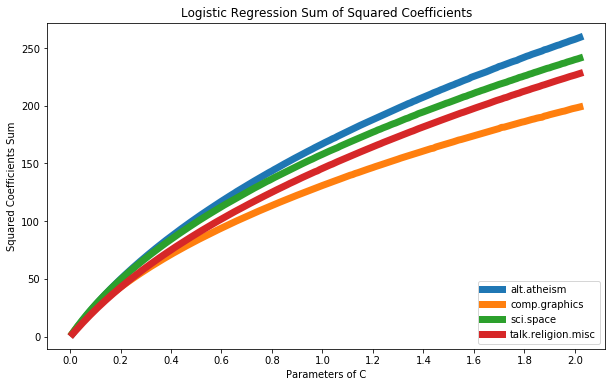

In [5]:
def P3():
### STUDENT START ###

    # Initializing the CountVectorizer() class, fitting, and transforming the training data 
    CV_train = CountVectorizer()
    CV_fit_train = CV_train.fit_transform(train_data)

    # Goal is just to transform to fit the same structure (vocabulary) as the 
    # train data. These two datasets will now have the same # of features but 
    # different observations
    CV_trans_dev = CV_train.transform(dev_data)

    def grid_search(classifier, name, param = None):
        """Searching for the best parameter per classifier and printing 
        the weighted score. For logistic regression, creating a sum of 
        the squared coefficients per C parameter and class"""
    
        GS_CV = GridSearchCV(classifier, param_grid = param, 
                             scoring="f1_weighted")
    
        # Fitting the training data
        GS_CV.fit(CV_fit_train, train_labels)

        # This is the best f1-score when the model predicts the dev data
        # Chose weighted parameter for the f1-score to weight the classes 
        # appropriately
        x = metrics.f1_score(dev_labels, GS_CV.predict(CV_trans_dev), 
                             average="weighted")

        # Printing the GS.CV_best_params variable without the dictionary
        best_param_key = list(GS_CV.best_params_.keys())
        best_param_print = list(GS_CV.best_params_.values())
        
        # The GS_CV.best_params_ is the best parameter for the model
        # The GS_CV.best_score_ is the best f1-score when the training data 
        # foldsover and the train data is split in half where half predicts 
        # the other half a couple of times
        print("\n\nBest" + "\033[1m", name, "\033[0m" + "value for parameter" 
              + "\033[1m", best_param_key, "\033[0m" + "is" + "\033[1m", 
              [float("%.6f" % i) for i in best_param_print], "\033[0m" + 
              "for this model", "\nThe weighted f1-score on the", name, 
              "model train data is" + "\033[1m", "%.4f" % GS_CV.best_score_, 
              "\033[0m" + "\nand the weighted f1-score on the", name, 
              "model predicting dev data is" + "\033[1m", "%.4f" % x + 
              "\033[0m")
    
        # Adding this step in for Logistic Regression for part C of the question above
        if name == "Logistic Regression": 
        
            # Assigning the parameter dictionary values to a new variable for 
            # easier manipulation
            LR_param = param['C']
        
            # Creating an empty matrix where the row is the number of C values
            # and the classes are the number of columns
            LR_Coefs_Sum_Squared = np.empty((len(LR_param),4))
        
            # Running the logistic regression for each value of C, per each class
            # Then squaring and summing the coefficients
            for i in range(len(LR_param)):
                LR = LogisticRegression(penalty = "l2", C = LR_param[i])
                LR.fit(CV_fit_train, train_labels)
            
                # Creating this calculation by the axis of the classes and
                # storing into each row of the C values expressed above
                LR_Coefs_Sum_Squared[i] = np.sum(LR.coef_**2, axis = 1)

            # Printing the first row of the table (i.e. the column headers)
            print("\n\n\033[1m" + "Coefficient Table" + "\033[0m", "\n ", 
                  "c_values", "\t", 
                  newsgroups_train.target_names[0], "\t", 
                  newsgroups_train.target_names[1], " ", "\t", 
                  newsgroups_train.target_names[2], "   ", 
                  newsgroups_train.target_names[3])
        
            # Printing the coefficient matrix for the remainder rows of the table
            for C, coefs in zip(LR_param, LR_Coefs_Sum_Squared):
                print ("\t", "%0.2f" % C, ["%13.2f" % x for x in coefs])
            
            # Printing a graph associated with the sum of the squared coefficients
            print("\n\n\033[1m" + "Coefficient Graph" + "\033[0m")
            fig = plt.figure(figsize=(10,6))
            plt.title('Logistic Regression Sum of Squared Coefficients')
            
            # Iterating through the sum of the squared coefficient variable to 
            # print unique lines for each class
            for i in range(LR_Coefs_Sum_Squared.shape[1]):
                plt.plot(LR_param, LR_Coefs_Sum_Squared[:,i], 
                         label = newsgroups_train.target_names[i], 
                         linewidth=7.0)
            plt.legend(loc = 'lower right')
            plt.xlabel('Parameters of C')
            plt.xticks(np.arange(0, 2.2, 0.2))
            plt.ylabel('Squared Coefficients Sum')
            plt.yticks(np.arange(0, 300, 50))
        
    # Calling the grid search function for all classifiers
    grid_search(KNeighborsClassifier(), "k Nearest Neighbors", 
                {"n_neighbors": np.arange(1,100,1)})
    grid_search(MultinomialNB(), "Multinomial Naive Bayes", 
                {"alpha": np.arange(0.001, 1.001, 0.001)})

    # Penalty is used to specify the type of loss function that we want to use and
    # measures how well the model fits the data compared with the model's complexity
    # to ideally achieve parsimony between complexity and generalization.
    # C is the inverse of the regularization strength and is telling the function
    # how strong to make l2
    grid_search(LogisticRegression(penalty = "l2"), "Logistic Regression", 
                {"C": np.arange(0.01, 2.02, 0.01)})

### STUDENT END ###
P3()

ANSWER: 

**Part A**

Nearest Neighbors does not work as well for this problem because we have a lot of zeros within the matrix, leading to a lot of sparsity. Many of the document examples within the training dataset contain very few of all of the unique words in the training dataset as the total feature space is quite large. In addition, some very common words are found in many documents that do not help predict the dev data very well. Nearest Neighbors works better for higher values of k as the prediction set of neighbors is larger and likely to have more features with meaningful coefficients.


**Part B**

Logistic regression does not work as well as Naive Bayes becauses logistic regression has a linear requirement, which is not helpful in this case. So many common words create a lot of noise, so it's very hard to fit an accurate line for logistic regression. Moreover, Naive Bayes has the independence assumption, which helps predict the development data in this case. While we know that the placement of words is not indepedent, we are modelling these features like a bag-of-words, making all features independent anyway without preserving word context. Therefore, the independence assumption is inherent in our modelling technique and in Naive Bayes, leading to a better prediction.


**Part C**

The sum of the squared coefficients and the parameters of C increase in a logarithmic relationship with each other. With smaller values of C, I have a larger penalty as the l2 penalty is stronger and the regularization strength is stronger too. Larger penalties will drive the coefficients down. On the contrary, when we have higher values of C, the l2 penalty is weaker with a lower regularization strength, allowing for higher coefficients.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [12]:
def P4():
### STUDENT START ###

    def table_creation (name, num_range):
        """Creating a table of the 5 features per class with the highest coefficients
        developed through Logistic Regression"""
        
        # Initializing the CountVectorizer() class, fitting, and transforming the data 
        CV_train = CountVectorizer(ngram_range=num_range)
        CV_fit_train = CV_train.fit_transform(train_data)

        # We only want to find the model weights so we can leave the C values out
        LR = LogisticRegression(penalty = "l2")

        # Fitting the logistic regression model
        LR.fit(CV_fit_train, train_labels)

        # Sorts something and returns an index (sorts a matrix and returns an index)
        # I want to sort the absolute value of the coefficients to get the largest
        # ones regardless of whether the coefficient is positive or negative
        # I pass in an axis of 1 as the np.argsort is on (row, column)
        # I want to take the last 5 as the sort is in reverse order and a comma
        # between the colon and the negative 5 lets me slice the last 5 per row 
        # (which is per class). Overall, defining the 5 indices (feature locations) 
        # with the highest coefficients per class
        last_5_per_class = np.argsort(np.absolute(LR.coef_), axis = 1)[:,-5:]

        print("\033[1m" + name, "Data Table:" + "\033[0m")

        # Creating my table of 4 columns (i.e. classes) and printing them out
        print("\n\t\t", newsgroups_train.target_names[0], "\t", 
              newsgroups_train.target_names[1], "\t", 
              newsgroups_train.target_names[2], "\t", 
              newsgroups_train.target_names[3])
    
        # Iterating through each class before we iterate through the last 5 per class
        for a in range(4):
    
            # Creating my table of 20 rows and putting my coefficents into the 
            # table. In the for loop below, we are printing out the words in each 
            # feature location. For this range, we want to go from 4 through 0 
            # (highest to lowest), stepping down by 1 each time
            for b in range (4,-1,-1):
            
                # Defining my coefficients before I put them into the table
                coef_1, coef_2, coef_3, coef_4 = LR.coef_[:,last_5_per_class[a,b]]
            
                # Printing out my rows
                print("%-12s" % CV_train.
                      get_feature_names()[last_5_per_class[a,b]], 
                      "\t", "%.2f" % coef_1, "\t\t", "%.2f" % coef_2, 
                      "\t\t", "%.2f" % coef_3, "\t\t", "%.2f" % coef_4)

    # Running the table with unigram features and then bigram features
    table_creation("Unigram Word", (1,1))
    table_creation("\n\n\nBigram Word", (2,2))


### STUDENT END ###
P4()

Unigram Word Data Table:

		 alt.atheism 	 comp.graphics 	 sci.space 	 talk.religion.misc
space        	 -1.26 		 -1.32 		 2.16 		 -1.17
deletion     	 1.12 		 -0.40 		 -0.42 		 -0.40
atheists     	 1.03 		 -0.10 		 -0.32 		 -0.84
bobby        	 0.99 		 -0.22 		 -0.34 		 -0.46
religion     	 0.95 		 -0.62 		 -0.79 		 -0.06
graphics     	 -0.76 		 1.94 		 -1.34 		 -0.76
image        	 -0.58 		 1.35 		 -0.83 		 -0.47
space        	 -1.26 		 -1.32 		 2.16 		 -1.17
file         	 -0.33 		 1.27 		 -0.81 		 -0.63
3d           	 -0.36 		 1.12 		 -0.70 		 -0.38
space        	 -1.26 		 -1.32 		 2.16 		 -1.17
graphics     	 -0.76 		 1.94 		 -1.34 		 -0.76
orbit        	 -0.41 		 -0.67 		 1.22 		 -0.63
nasa         	 -0.57 		 -0.48 		 1.01 		 -0.47
launch       	 -0.47 		 -0.47 		 0.94 		 -0.33
space        	 -1.26 		 -1.32 		 2.16 		 -1.17
christians   	 -0.74 		 -0.41 		 -0.53 		 1.15
christian    	 -0.61 		 -0.42 		 -0.27 		 1.12
blood        	 -0.53 		 -0.11 		 -0.32 		 1.05
could        	 0.

ANSWER:

First, I am assuming that the question is asking for the largest absolute value as opposed to only the largest value to account for coefficients in all directions. This helps us understand features that do and do not belong in a given class. I also see some overlap between the unigram and bigram word lists in that both lists include words such as space and graphics, and words related to space such as moon, orbit, nasa, launch, "out there", "look up", etc.

The unigram words are also less generic than the bigram words as the unigram words are almost all nouns describing categories, while the bigram words include phrases such as "was just", "looking for", "is there", which do not easily describe one category or another. This pattern could be a reason why the unigram word coefficients are a bit higher overall and are likely better predictors of the class.

I also see some duplicates within classes for unigram with the word space, and for bigram with the phrase "looking for". These duplicates could lead to confusing predictions as both the word space and the phrase "looking for" can be a ton of different things. Moreover, while "space" shows up as a word with a high coefficient for all classes, this word only shows up with a positive coefficient in the "sci.science" class, speaking to the only class it really belongs in.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [11]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    
    # Lowercase the entre training dataset
    s = s.lower()
    
    # Remove all special characters and replace with a space using regex
    s = re.sub("[^\w\d]"," ", s)
    
    # Remove all "ly's" at the end of the word
    s = re.sub("ly "," ", s)
    
    # Remove all defined stop words
    s = ' '.join([word for word in s.split(" ") if word not in 
                  ENGLISH_STOP_WORDS])
    
    
    # Other ideas that did not work:
    
    # Uppercase the entire training dataset
    # s = s.upper()
    
    # Only keep characters a-z, A-Z and 0-9 and replace others with a space
    # s = re.sub ('[^a-zA-Z0-9]',' ',s)
    
    # Remove all "ing's" at the end of the word
    # s = re.sub("ing "," ", s)
    
    # Removing all numbers from the dataset
    # s = re.sub("[1234567890]"," ", s)
    
    return s

### STUDENT END ###


def P5():
### STUDENT START ###

    def grid_search(processor, name):
        """Running a logistic regression on different CountVectorizer() 
        prepressors and comparing the weighted f1-scores"""

        # Initializing the CountVectorizer() class, fitting, and transforming the data 
        # The preprocessor attribute is called preprocessor and it processes one string
        # at a time before CountVectorizer() fits and transforms the data
        CV_train = CountVectorizer(preprocessor = processor)
        CV_fit_train = CV_train.fit_transform(train_data)
        CV_trans_dev = CV_train.transform(dev_data)
    
        # Print size of dictionary
        print("\n\nUnique words in training data with the logistic regression " 
              + "\033[1m", name ,": ", CV_fit_train.shape[1], sep="")

        GS_CV = GridSearchCV(LogisticRegression(penalty = "l2"), 
                             param_grid = {"C": np.arange(0.01, 5.02, 0.1)}, 
                             scoring="f1_weighted")
    
        # Fitting the training data
        GS_CV.fit(CV_fit_train, train_labels)

        # This is the best f1-score when model predicts the dev data
        x = metrics.f1_score(dev_labels, GS_CV.predict(CV_trans_dev), 
                             average="weighted")

        # Printing the GS.CV_best_params variable without the dictionary
        best_param_key = list(GS_CV.best_params_.keys())
        best_param_print = list(GS_CV.best_params_.values())
        
        # The GS_CV.best_params_ is the best parameter for the model
        print("\n\033[0m" + "Best logistic regression", name, "value for", 
              best_param_key, "is:", [float("%.6f" % i) for i in best_param_print], 
              "for this model", "\nThe weighted f1-score on the", name, 
              "model predicting dev data is", "\033[1m" + "%.4f" % x + 
              "\033[0m")

    # The performance for the empty_preprocessor is worse than what we see in Q3
    # as the default processor is not empty
    grid_search(empty_preprocessor, "empty processor")
    grid_search(better_preprocessor, "better processor")
    
### STUDENT END ###
P5()



Unique words in training data with the logistic regression empty processor: 33291

Best logistic regression empty processor value for ['C'] is: [0.81] for this model 
The weighted f1-score on the empty processor model predicting dev data is 0.7038


Unique words in training data with the logistic regression better processor: 26121

Best logistic regression better processor value for ['C'] is: [0.31] for this model 
The weighted f1-score on the better processor model predicting dev data is 0.7328


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]


Number of features with any nonzero weights in Logistic Regression with l1 penalty: 1061
Number of all nonzero weights in Logistic Regression with l1 penalty: 1814

Number of features with any nonzero weights in Logistic Regression with l2 penalty: 26879
Number of all nonzero weights in Logistic Regression with l2 penalty: 107516


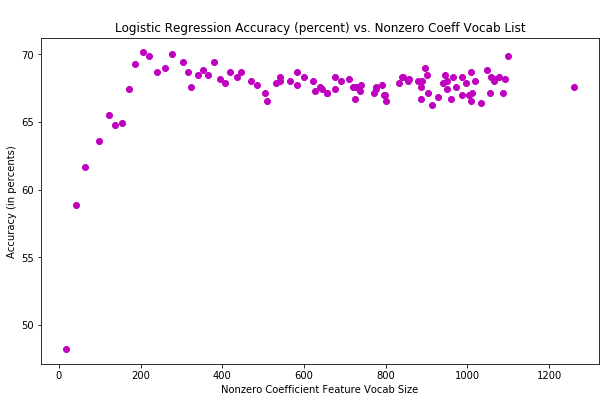



----------


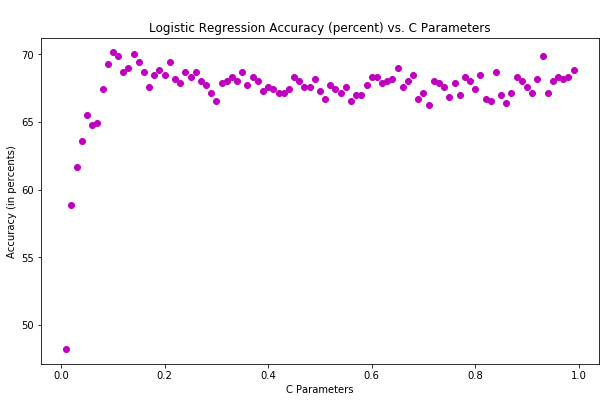



----------


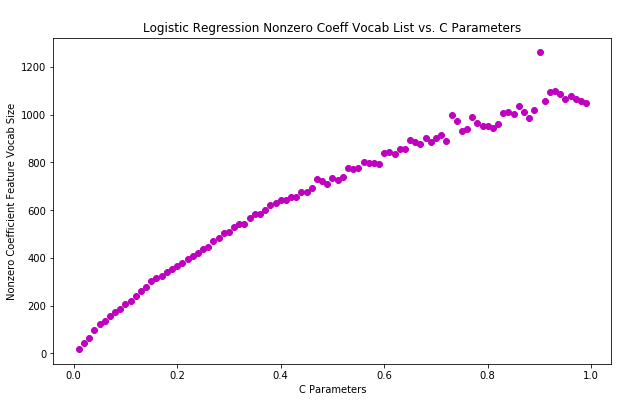

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    # Initializing the CountVectorizer() class, fitting, and transforming the data 
    CV_train = CountVectorizer()
    CV_fit_train = CV_train.fit_transform(train_data)
    CV_trans_dev = CV_train.transform(dev_data)
    
    def penalty (value):
        """Running a logistic regression based on a certain penalty value
        and printing out the number of nonzero features"""
        
        # Fitting a logistic regression model with a specific penalty
        # L1 penalizes the absolute value of the weights and is more sparse
        # L2 penalizes the square of the weights
        # Using a tolerance of 0.01 to relax the convergence criteria
        LR = LogisticRegression(penalty = value, tol=0.01)
        LR.fit(CV_fit_train, train_labels)
        
        # We are looking at each row, which represents one class
        # While every column represents one feature (or one word)
        # We want to count all of the non-zero feature coefficients
        LR_nonzero_any = np.any(LR.coef_ !=0, axis = 0)
        print("\n\033[0m" + "Number of features with any nonzero weights in",
              "Logistic Regression with" + "\033[1m", value, "penalty:", 
              sum(LR_nonzero_any))
        
        # Counting all nonzero coefficient values as opposed to any row where 
        # there is at least one nonzero value
        LR_nonzero_all = np.count_nonzero(LR.coef_)
        print("\033[0m" + "Number of all nonzero weights in Logistic Regression", 
              "with" + "\033[1m", value, "penalty:", LR_nonzero_all)
    
    penalty("l1")
    penalty("l2")
    
    
    # Initializing a list of accuracies and a new vocab list
    LR_l2_new_accuracies = []
    new_array_vocab_list = []
    
    # Looping through values of C to get accuracy by nonzero vocab size
    for C in np.arange(0.01, 1, 0.01):
        
        # Fitting a logistic regression for penalty L1, similar to above,
        # but now for each value of C
        LR_new = LogisticRegression(penalty = "l1", C = C, tol = 0.01)
        LR_new.fit(CV_fit_train, train_labels)
        LR_new_nonzero = np.any(LR_new.coef_ != 0, axis = 0)
        
        # Counts the number of True values 
        # (sums all of the 1's as True in binary is 1)
        new_array_vocab_list.append(sum(LR_new_nonzero))
        
        # This is our vocabulary (of features)
        # We are converting to an array so that we can use it with,
        # LR_new_nonzero, which is a Boolean, and we will apply it to the
        # array that we are creating below, which will only keep
        # the words with a nonzero coefficient. The new_array_vocab 
        # variable will only keep words where LR_new_nonzero = True
        new_array_vocab = np.array(CV_train.
                                   get_feature_names())[LR_new_nonzero]
        
        # Vectorizing the new non-zero vocab and fitting to our training data
        CV_train_new_nonzero = CountVectorizer(vocabulary = new_array_vocab)
        CV_trans_train_new_nonzero = CV_train_new_nonzero.transform(train_data)
        CV_trans_dev_new_nonzero = CV_train_new_nonzero.transform(dev_data)
        
        # Fitting a logistic regression for penalty L2 with our new nonzero vocab
        # Did not pass through a C here in order to keep a consistent
        # C value as I ran this logistic regression
        LR_l2_new_nonzero = LogisticRegression(penalty = "l2", tol = 0.01)
        LR_l2_new_nonzero.fit(CV_trans_train_new_nonzero, train_labels)
        
        # Evaluating the accuracy of the logistic regression on our dev data
        # and appending to our accuracy list
        accuracy = LR_l2_new_nonzero.score(CV_trans_dev_new_nonzero, 
                                           dev_labels)
        LR_l2_new_accuracies.append(accuracy)

    # Printing a scatterplot for our nonzero feature vocab size against our accuracy
    plt.figure(figsize=(10,6))
    plt.plot(new_array_vocab_list, np.array(LR_l2_new_accuracies)*100,"mo")
    plt.title('\nLogistic Regression Accuracy (percent) vs. Nonzero Coeff Vocab List')
    plt.xlabel('Nonzero Coefficient Feature Vocab Size')
    plt.ylabel('Accuracy (in percents)')
    plt.show()
    
    print("\n\n"  "----------")
    
    # For comparison, printing a scatterplot for the C values against the accuracy
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0.01, 1, 0.01), np.array(LR_l2_new_accuracies)*100,"mo")
    plt.title('\nLogistic Regression Accuracy (percent) vs. C Parameters')
    plt.xlabel('C Parameters')
    plt.ylabel('Accuracy (in percents)')
    plt.show()
    
    print("\n\n"  "----------")
    
    # For comparison, printing a scatterplot for the C values against the vocab size
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0.01, 1, 0.01), new_array_vocab_list,"mo")
    plt.title('\nLogistic Regression Nonzero Coeff Vocab List vs. C Parameters')
    plt.xlabel('C Parameters')
    plt.ylabel('Nonzero Coefficient Feature Vocab Size')
    plt.show()

    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [9]:
def P7():
    ### STUDENT START ###
    
    # Initializing the TfidfVectorizer() class, fitting, and transforming the data 
    TV_train = TfidfVectorizer()
    TV_fit_train = TV_train.fit_transform(train_data)
    TV_trans_dev = TV_train.transform(dev_data)
    
    LR_l2 = LogisticRegression(penalty = "l2", C = 100)
    LR_l2.fit(TV_fit_train, train_labels)
    print("Accuracy for logistic regression prediction on Dev Data:" + 
          "\033[1m", "%.4f" % LR_l2.score(TV_trans_dev, dev_labels))
    
    print("\033[0m" + "F1-score for logistic regression prediction on", 
          "Dev Data:" + "\033[1m", "%.4f" % 
          metrics.f1_score(dev_labels, LR_l2.predict(TV_trans_dev), 
                           average="weighted"))
    
    # Prediction probability for each document for each class
    # Therefore, each document has four distinct probabilities
    Pred_Prob_Dev = LR_l2.predict_proba(TV_trans_dev)
    
    # Calling the maximum predicted probability of each document. 
    # The axis = 1 this time because each column represents a class 
    # and we want the highest probability per doc
    Max_Pred_Prob_Dev = np.amax(Pred_Prob_Dev, axis=1)
    
    # By calling np.arange, we are looping through the length of the dev_labels
    # and returning the highest probability for the class of dev labels
    Pred_Prob_Correct_Label = (Pred_Prob_Dev[np.arange(len(dev_labels)), 
                                             dev_labels])
    
    Ratio_R = Max_Pred_Prob_Dev / Pred_Prob_Correct_Label
    
    Top_3_Docs = np.argsort(Ratio_R)[-3:]
    
    # Print documents from the highest Ratio_R to the lowest of the top 3
    for i in reversed(Top_3_Docs):
        
        # Pred_Prob_Dev[i,:] is looking at every column for 
        # each document (each row)
        # We want the maximum probability as that would be the predicted label
        print("\033[0m" + "\n\nexample number:" + "\033[1m", i, 
              "\033[0m" + "\nratio of max pred prob over the pred prob of the" 
              "correct label:", "\033[1m" + "%.2f" % Ratio_R[i] + "\033[0m",
              "\npredicted dev label:", "\033[1m" + 
              newsgroups_train.target_names[np.argmax(Pred_Prob_Dev[i,:])] + 
              "\033[0m", "\nactual dev label:", "\033[1m" + 
              newsgroups_train.target_names[dev_labels[i]] + "\033[0m",
              "\ndev document text:\n", dev_data[i], "\n\n----------")

    ### STUDENT END ###
P7()

Accuracy for logistic regression prediction on Dev Data: 0.7633
F1-score for logistic regression prediction on Dev Data: 0.7598


example number: 215 
ratio of max pred prob over the pred prob of thecorrect label: 929.36 
predicted dev label: comp.graphics 
actual dev label: talk.religion.misc 
dev document text:
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to mak

ANSWER:

CountVectorizer simply takes the frequency of a specific feature in one document. The shortfall here is that CountVectorizer does not take the length of the document into account (a longer document is guaranteed to have more words). Therefore, bias will appear in this measurement, overweighting features that appear multiple times in a short document, and underweighting in a long document (as we have more words to contend with).

TfidfVectorizer takes the frequency of a specific feature in one document and then multiplies the frequency by its inverse frequency across all documents. Therefore, TfidfVectorizer accesses all documents to determine the weight of a specific term, to hopefully adjust the potential biases between short and long documents. The goal here is to normalize the frequency of each term to avoid bias. 

One shortfall here with both methods though is that frequency does not always suggest importance, expecially in stop words. Also, different words mean different things depending on the context. One issue we see is that a document is requesting "ftp site" information, and overweighting terms associated with this (such as internet, email, RTF, postscript, etc.) to predict a label of "comp.graphics". In realty, the term "Mormon" should have been weighted higher as the actual label is "talk.religion.misc", even if the word was not mentioned that many times within the document.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [15]:
def empty_preprocessor_EC(s):
    return s

def better_preprocessor_EC(s):
    
    # Lowercase the entre training dataset
    s = s.lower()
    
    # Remove all special characters and replace with a space using regex
    s = re.sub("[^\w\d]"," ", s)
    
    # Remove all "ly's" at the end of the word
    s = re.sub("ly "," ", s)
    
    # Remove all defined stop words
    s = ' '.join([word for word in s.split(" ") if word not in 
                  ENGLISH_STOP_WORDS])
    
    # Remove additional words ['copyright', 'internet', 'ftp', 'postscript', 
    # .                        'ascii', 'latex', 'email', 'address', 'site',
    #                          'mormon', 'jesus', 'christ', 'baptist', 'lord',
    #                          'devil', 'history', 'child', 'christian', 'gun', 
    #                          'god', 'book', 'guilty', 'solar', 'romans',
    #                          'belief', 'software', 'burden', 'proof', 'islam',
    #                          'muslim', 'edit', 'fly', 'computer', 'programs'
    #                          'killed', 'gunman', 'online', 'bullets'
    #                          'cheers kent', 'space', 'graphics', 'nasa'])
    # The words in the list above did not help the f1-score, but were tried
    s = ' '.join([word for word in s.split(" ") 
                  if word not in ['historical', 'children', 'bible', 
                                  'launch', 'atheists']])
    
    return s


def P8_EC(processor, name):
    ### STUDENT START ###
    
    TV_train = TfidfVectorizer(preprocessor = processor)
    TV_fit_train = TV_train.fit_transform(train_data)
    TV_trans_dev = TV_train.transform(dev_data)
    
    LR_l2 = LogisticRegression(penalty = "l2", C = 100)
    LR_l2.fit(TV_fit_train, train_labels)
    print("\033[0m" + "\n", name, "Accuracy for logistic regression",
          "prediction on Dev Data:" + "\033[1m", 
          "%.4f" % LR_l2.score(TV_trans_dev, dev_labels))
    
    print("\033[0m" + "", name, "F1-score for logisitic regression prediction", 
          "on Dev Data:" + "\033[1m", "%.4f" % 
          metrics.f1_score(dev_labels, LR_l2.predict(TV_trans_dev), 
                           average="weighted"))

P8_EC(empty_preprocessor_EC, "Empty Extra Credit Processor:")
P8_EC(better_preprocessor_EC, "Better Extra Credit Processor:")


 Empty Extra Credit Processor: Accuracy for logistic regression prediction on Dev Data: 0.7633
 Empty Extra Credit Processor: F1-score for logisitic regression prediction on Dev Data: 0.7590

 Better Extra Credit Processor: Accuracy for logistic regression prediction on Dev Data: 0.7914
 Better Extra Credit Processor: F1-score for logisitic regression prediction on Dev Data: 0.7880
